# Magnification factor of $\beta$-VAE toy example
[Yusuke Hayashi](https://github.com/hayashiyus)<br/>
April 30, 2024 <br/>

## Variational inference
Given samples $x$ from an unobserved data density $q(x)$, we are interested in building a latent-variable generative model $p_{\varphi}(x, z)$ such that $p(x)$ is close to $q(x)$. This is a difficult problem as evaluating the density under the model, $p(x)$ requires evaluating an intractable integral over the unobserved latent variable $z$: $p_{\varphi}(x)=\int \mathrm{d}z \;p_{\varphi}(x, z)$.
$$
\begin{gathered}
q_\phi(x, z) = q(x) q_\phi(z \mid x) \\
p_{\varphi}(x, z) = p(z) p_{\varphi}(x \mid z)
\end{gathered}
$$
The variational principle bypasses this problem by optimizing a lower bound on the log-likelihood of the data. In this case, the objective $\mathcal{L}_{\mathrm{VAE-ELBO}}$:
$$
\begin{aligned}
\mathbb{E}_{q(x)}\left[\log p_{\varphi}(x)\right] & =\mathbb{E}_{q(x)}\left[\log \int p_{\varphi}(x, \psi) d \psi\right] \\
& =\mathbb{E}_{q(x)}\left[\log \int q_\phi(\psi \mid x) \frac{p_{\varphi}(x, \psi)}{q_\phi(\psi \mid x)} d \psi\right] \\
& \geq \mathbb{E}_{q(x)}\left[\int q_\phi(\psi \mid x) \log \frac{p_{\varphi}(x, \psi)}{q_\phi(\psi \mid x)} d \psi\right] \\
& =\mathbb{E}_{q_\phi(x, \psi)}\left[\log p_{\varphi}(x \mid \psi)\right]-\mathbb{E}_{q(x)}\left[D_{\mathrm{KL}}\left(q_\phi(\psi \mid x) \| p(\psi)\right)\right] := \mathcal{L}_{\mathrm{VAE-ELBO}}
\end{aligned}
$$
The objective of $\beta$-VAE $\mathcal{L}_{\beta-\mathrm{VAE}}$ is given as a slight modification of the ELBO of VAE:
$$
\mathcal{L}_{\beta-\mathrm{VAE}} := \mathbb{E}_{q_\phi(x, z)}\left[\log p_{\varphi}(x \mid z)\right]-\frac{1}{\beta} \mathbb{E}_{q(x)}\left[D_{\mathrm{KL}}\left(q_\phi(z \mid x) \| p(z)\right)\right]
$$
The objective of $\beta$-VAE $\mathcal{L}_{\beta-\mathrm{VAE}}$ can be derived according to the variational principle by modifying the respective encoder and decoder models as follows:
$$
\begin{aligned}
& q_{\beta, \phi}(x, z)=\frac{q^\beta(x) q_\phi(z \mid x)}{Z_q(\beta)} . \\
& p_{\beta, \varphi}(x, z)=\frac{p(z) p_{\varphi}^\beta(x \mid z)}{Z_p(\beta)} .
\end{aligned}
$$
$$
\begin{aligned}
\mathcal{L}_{\mathrm{Neq-VAE}} &:= \mathbb{E}_{q_{\beta, \phi}(x, z)}\left[\log p_{\varphi}(x \mid z)\right]-\frac{1}{\beta} \mathbb{E}_{q^\beta(x)}\left[D_{\mathrm{KL}}\left(q_\phi(z \mid x) \| p(z)\right)\right]
\end{aligned}
$$
$$
\begin{aligned}
-\frac{1}{\beta} D_{\mathrm{KL}}\left(q_{\beta, \phi}(x, z) \| p_{\beta, \varphi}(x, z)\right) & =-\frac{1}{\beta} \mathbb{E}_{q_{\beta, \phi}(x, z)}\left[\log \frac{q_{\beta, \phi}(x, z)}{p_{\beta, \varphi}(x, z)}\right] \\
& =-\frac{1}{\beta} \mathbb{E}_{q_{\beta, \phi}(x, z)}\left[\log \frac{Z_p(\beta) q^\beta(x) q_\phi(z \mid x)}{Z_q(\beta) p(z) p_{\varphi}^\beta(x \mid z)}\right] \\
& =\frac{1}{\beta}\left(-\log \frac{Z_p(\beta)}{Z_q(\beta)}+H_{q_\phi^\beta}(x)\right)+\mathcal{L}_{\text{Neq-VAE}} \\
& \geq \frac{1}{\beta}\left(-\log \frac{Z_p(\beta)}{Z_q(\beta)}+H_{q_\phi^\beta}(x)\right)+\mathcal{L}_{\beta-\mathrm{VAE}} .
\end{aligned}
$$

This lower bound depends on an additional distribution, $q(z|x)$ which is known as the _variational distribution_ and acts as an approximation to the true posterior $p(z|x)$. 
To evaluate and learn using the variational lower bound, we need to be able to draw samples from the _variational distribution_ and to evaluate the density of a sample from the _variational distribution_. This typically restricts the family of variational distributions to those with known or tractable densities (e.g. factorial Gaussian, normalizing flows).

Send questions/comments/bugs to [@hayashiyus](https://twitter.com/hayashiyus).

## Create dataset of one-hot vectors

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Bernoulli
from torch.utils.data import DataLoader, TensorDataset
from sklearn import datasets
import sklearn.preprocessing as sp
import sklearn.model_selection as sm
import matplotlib
import mplcyberpunk
import matplotlib.cm as cm
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

plt.style.use("cyberpunk")

# Load training datasets
MNIST = datasets.load_digits()
X = MNIST.data  # X: images
X = X / 16  # Normalize pixel values
yl = MNIST.target  # yl: labels
D, n = X.shape

n_im_row, n_im_col = 5, 15
n_im = n_im_row * n_im_col
d = np.arange(D)
d_choice = np.random.choice(np.arange(D), n_im, replace=False)

n_px_row = np.floor(np.sqrt(n)).astype('int')
n_px_col = (n / n_px_row).astype('int')

# Split the dataset into train and test datasets
X_train, X_test, yl_train, yl_test = sm.train_test_split(X, yl, train_size=1/2, test_size=1/2)

X_test = X_test[:-1]
yl_test = yl_test[:-1]

# create dataset of one-hot vectors
# class size
C = 10                      
# .A means 'change the data type from a matrix to an array'
enc = sp.OneHotEncoder()
Y_train = enc.fit_transform(yl_train.reshape(-1, 1)).A
Y_test = enc.fit_transform(yl_test.reshape(-1, 1)).A

print('訓練データ数：D_train =', len(Y_train))
print('テストデータ数：D_test =', len(Y_test))

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
Y_test = torch.tensor(Y_test, dtype=torch.long)

訓練データ数：D_train = 898
テストデータ数：D_test = 898


## Setup

In [2]:
# Constants
n_epoch = 100000 + 1
batch_size = X_train.shape[0]
latent_dim = 2  # Assuming latent_dim is 2 for this example
n_layer = 4  # Assuming n_layer is 4 for this example
n_unit = 256  # Assuming n_unit is 256 for this example
output_dim = Y_train.shape[1]  # Assuming output_dim is the number of classes

# Data
x = torch.tensor(X_train, dtype=torch.float32)
y = torch.tensor(Y_train, dtype=torch.float32)

# データセットの準備
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Encoder network
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc_layers = nn.Sequential(*[nn.Linear(hidden_dim if i > 0 else input_dim, hidden_dim) for i in range(n_layer)])
        self.loc = nn.Linear(hidden_dim, latent_dim)
        self.scale = nn.Linear(hidden_dim, latent_dim)
        self.softplus = nn.Softplus()
    
    def forward(self, x):
        enc = self.fc_layers(x)
        loc = self.loc(enc)
        scale = 1e-6 + (1 - 2e-6) * self.softplus(self.scale(enc))
        return loc, scale

# Decoder network
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_layers = nn.Sequential(*[nn.Linear(hidden_dim if i > 0 else latent_dim, hidden_dim) for i in range(n_layer)])
        self.dec = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, z):
        dec = self.fc_layers(z)
        dec = 1e-6 + (1 - 2e-6) * self.sigmoid(self.dec(dec))
        return dec

# Instantiate networks
encoder = Encoder(input_dim=x.shape[1], hidden_dim=n_unit, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=n_unit, output_dim=output_dim)
encoder_params = dict(encoder.named_parameters())
decoder_params = dict(decoder.named_parameters())

/var/folders/fw/ch0md4dj6x353_sr7k4k_f3r0000gq/T/ipykernel_94032/2164076786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X_train, dtype=torch.float32)
/var/folders/fw/ch0md4dj6x353_sr7k4k_f3r0000gq/T/ipykernel_94032/2164076786.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(Y_train, dtype=torch.float32)
/var/folders/fw/ch0md4dj6x353_sr7k4k_f3r0000gq/T/ipykernel_94032/2164076786.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tens

In [3]:
def compute_jacobian(model, params, input):
    func = torch.func.functional_call(model, params, input)
    output_dim = func.shape[1]
    #J = [torch.autograd.grad(outputs=func[:, i], inputs=input, grad_outputs=torch.ones_like(func[:, i]), allow_unused=True, retain_graph=True, create_graph=True)[0] for i in range(output_dim)]
    J = [torch.autograd.grad(outputs=func[:, i], inputs=input, grad_outputs=func[:, i], allow_unused=True, retain_graph=True, create_graph=False)[0] for i in range(output_dim)]
    J = torch.stack(J, dim=1)  # batch x output x latent
    return J

def compute_logprobs(model, params, input, cyclical_beta, j):
    func = torch.func.functional_call(model, params, input)
    log_probs = Bernoulli(probs=func.pow_(cyclical_beta[j])).log_prob(y)
    output_dim = func.shape[1]
    #J = [torch.autograd.grad(outputs=log_probs[:, i], inputs=input, grad_outputs=torch.ones_like(log_probs[:, i]), allow_unused=True, retain_graph=True, create_graph=True)[0] for i in range(output_dim)]
    J = [torch.autograd.grad(outputs=log_probs[:, i], inputs=input, grad_outputs=log_probs[:, i], allow_unused=True, retain_graph=True, create_graph=False)[0] for i in range(output_dim)]
    J = torch.stack(J, dim=1)  # batch x output x latent
    return J

def compute_magnification_factor(J):
    """
    creates the metric tensor (J^T J and J being the jacobian of the decoder), 
    which can be evaluated at any point in Z
    and
    the magnification factor
    """
    G = torch.matmul(J.permute(0, 2, 1), J)  # J^T \cdot J
    # magnification factor
    mf = torch.sqrt(torch.det(G))
    return mf

def compute_fisher_information_factor(J):
    """
    Computes the Fisher Information Factor using the Jacobian matrix.
    
    Args:
    - jacobian (torch.Tensor): The Jacobian matrix. Shape: [batch_size, output_dim, input_dim].
    
    Returns:
    - fif (torch.Tensor): The Fisher Information Factor. Shape: [batch_size].
    """
    G = torch.matmul(J.permute(0, 2, 1), J)  # J^T \cdot J
    # fisher information factor
    fif = torch.diagonal(G, dim1=1, dim2=2).sum(dim=1)
    return fif

def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    tiled_x = x.view(x_size, 1, dim).expand(x_size, y_size, dim)
    tiled_y = y.view(1, y_size, dim).expand(x_size, y_size, dim)
    return torch.exp(-torch.mean((tiled_x - tiled_y) ** 2, dim=2) / dim)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)

  0%|          | 0/100001 [00:00<?, ?it/s]

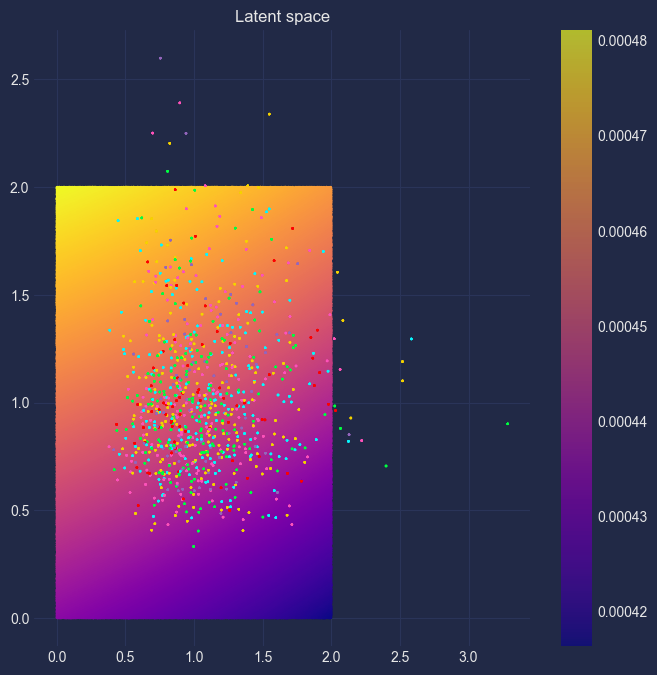

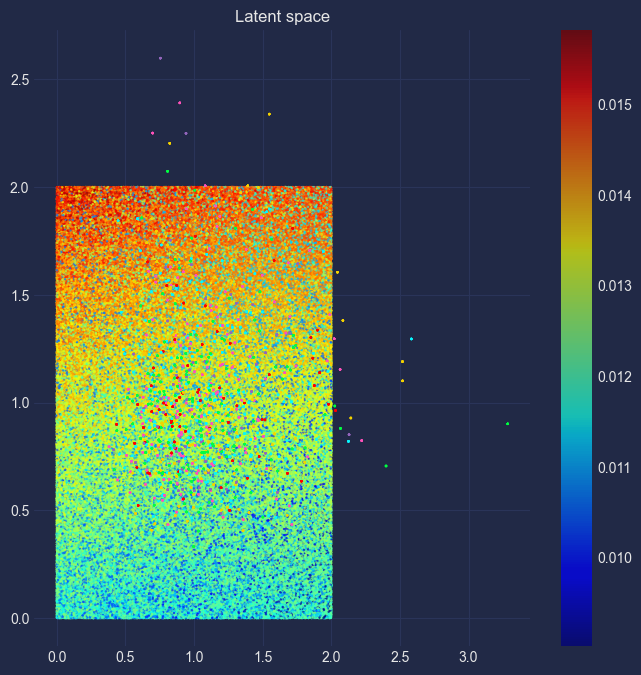

  0%|          | 14/100001 [00:20<29:34:03,  1.06s/it]

    0:(beta)=(    0.8000)


  1%|          | 1024/100001 [00:29<13:39, 120.73it/s]

 1000:(beta)=(    0.6082)


  2%|▏         | 2017/100001 [00:37<13:28, 121.15it/s]

 2000:(beta)=(    0.6912)


  3%|▎         | 3016/100001 [00:45<13:28, 119.88it/s]

 3000:(beta)=(    0.9301)


  4%|▍         | 4014/100001 [00:54<13:01, 122.75it/s]

 4000:(beta)=(    0.9826)


  5%|▌         | 5023/100001 [01:02<13:13, 119.67it/s]

 5000:(beta)=(    0.7735)


  6%|▌         | 6019/100001 [01:10<12:57, 120.84it/s]

 6000:(beta)=(    0.6024)


  7%|▋         | 7022/100001 [01:19<13:28, 114.97it/s]

 7000:(beta)=(    0.7144)


  8%|▊         | 8023/100001 [01:28<12:58, 118.16it/s]

 8000:(beta)=(    0.9491)


  9%|▉         | 9015/100001 [01:36<12:56, 117.15it/s]

 9000:(beta)=(    0.9701)


 10%|▉         | 9998/100001 [02:00<12:41, 118.17it/s]

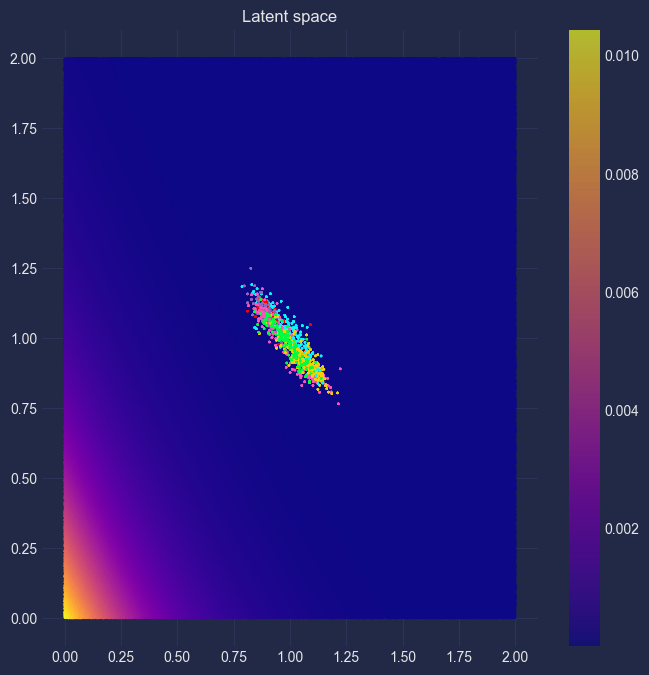

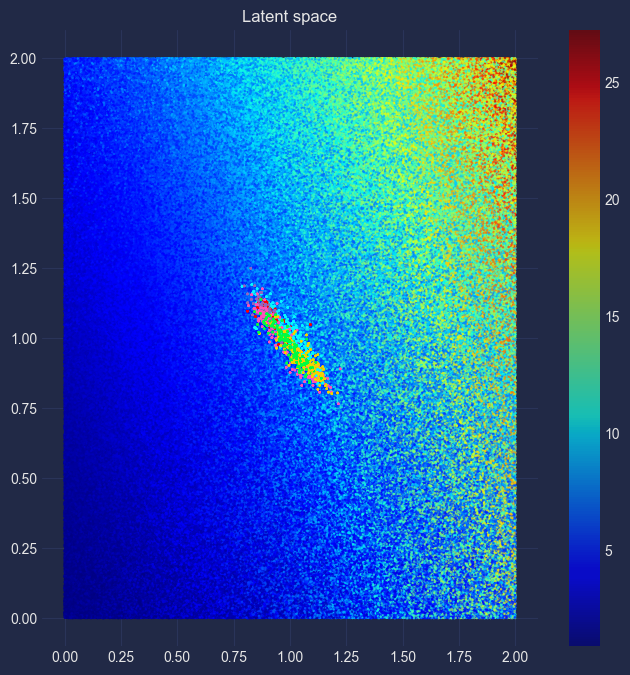

 10%|█         | 10014/100001 [02:05<10:31:49,  2.37it/s]

10000:(beta)=(    0.7474)


 11%|█         | 11017/100001 [02:14<11:45, 126.14it/s]  

11000:(beta)=(    0.6000)


 12%|█▏        | 12019/100001 [02:22<11:42, 125.26it/s]

12000:(beta)=(    0.7392)


 13%|█▎        | 13025/100001 [02:30<11:31, 125.70it/s]

13000:(beta)=(    0.9654)


 14%|█▍        | 14016/100001 [02:38<12:01, 119.13it/s]

14000:(beta)=(    0.9547)


 15%|█▌        | 15024/100001 [02:46<11:25, 123.98it/s]

15000:(beta)=(    0.7223)


 16%|█▌        | 16020/100001 [02:54<11:17, 123.89it/s]

16000:(beta)=(    0.6012)


 17%|█▋        | 17022/100001 [03:02<11:07, 124.25it/s]

17000:(beta)=(    0.7650)


 18%|█▊        | 18018/100001 [03:11<11:53, 114.91it/s]

18000:(beta)=(    0.9789)


 19%|█▉        | 19011/100001 [03:19<09:32, 141.40it/s]

19000:(beta)=(    0.9365)


 20%|█▉        | 19991/100001 [03:40<10:43, 124.36it/s]

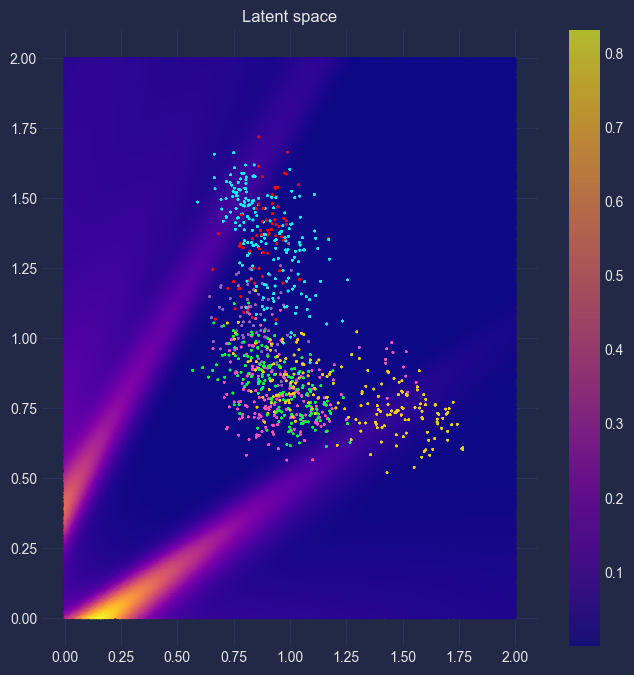

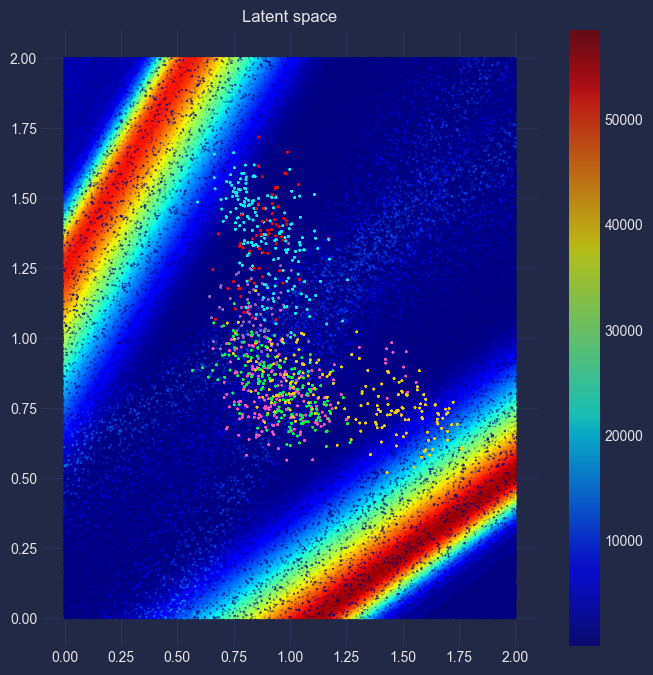

 20%|██        | 20014/100001 [03:45<7:10:25,  3.10it/s] 

20000:(beta)=(    0.6986)


 21%|██        | 21014/100001 [03:53<10:12, 128.95it/s] 

21000:(beta)=(    0.6059)


 22%|██▏       | 22019/100001 [04:01<09:27, 137.41it/s]

22000:(beta)=(    0.7914)


 23%|██▎       | 23025/100001 [04:08<09:23, 136.58it/s]

23000:(beta)=(    0.9892)


 24%|██▍       | 24017/100001 [04:16<09:09, 138.30it/s]

24000:(beta)=(    0.9159)


 25%|██▌       | 25017/100001 [04:24<08:52, 140.71it/s]

25000:(beta)=(    0.6766)


 26%|██▌       | 26023/100001 [04:31<08:48, 140.09it/s]

26000:(beta)=(    0.6141)


 27%|██▋       | 27022/100001 [04:38<08:37, 141.15it/s]

27000:(beta)=(    0.8179)


 28%|██▊       | 28016/100001 [04:46<09:44, 123.20it/s]

28000:(beta)=(    0.9961)


 29%|██▉       | 29022/100001 [04:53<08:16, 143.09it/s]

29000:(beta)=(    0.8933)


 30%|██▉       | 29991/100001 [05:20<08:39, 134.89it/s]

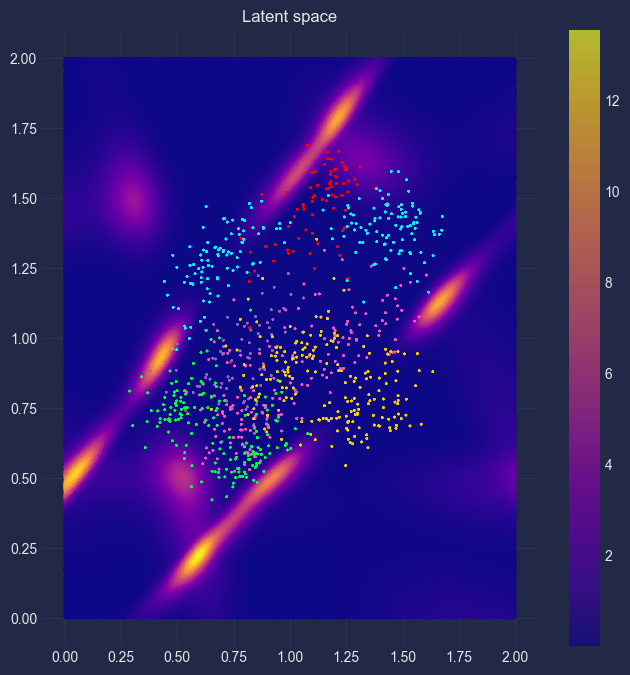

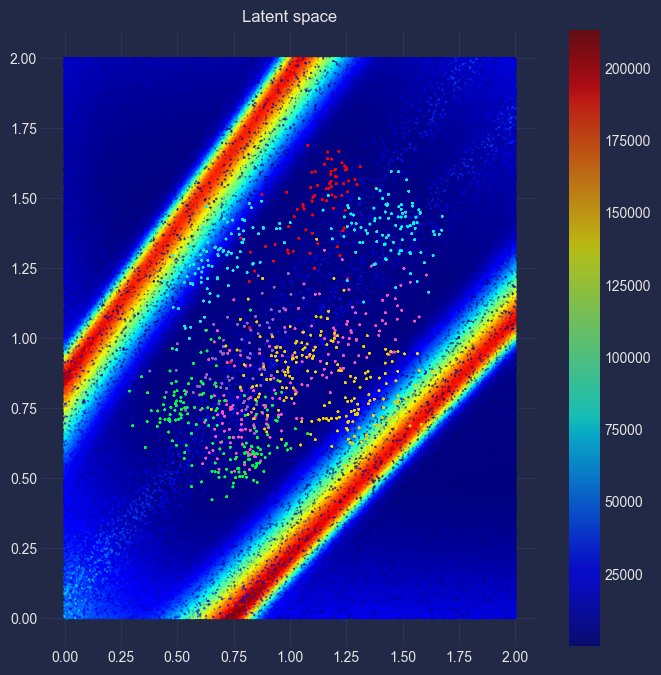

 30%|███       | 30011/100001 [05:22<7:35:00,  2.56it/s] 

30000:(beta)=(    0.6568)


 31%|███       | 31024/100001 [05:31<09:37, 119.41it/s] 

31000:(beta)=(    0.6255)


 32%|███▏      | 32024/100001 [05:39<09:13, 122.71it/s]

32000:(beta)=(    0.8442)


 33%|███▎      | 33021/100001 [05:47<09:31, 117.27it/s]

33000:(beta)=(    0.9996)


 34%|███▍      | 34023/100001 [05:56<08:53, 123.61it/s]

34000:(beta)=(    0.8690)


 35%|███▌      | 35013/100001 [06:04<08:54, 121.62it/s]

35000:(beta)=(    0.6396)


 36%|███▌      | 36023/100001 [06:12<09:02, 117.87it/s]

36000:(beta)=(    0.6400)


 37%|███▋      | 37023/100001 [06:21<08:48, 119.16it/s]

37000:(beta)=(    0.8697)


 38%|███▊      | 38016/100001 [06:29<08:52, 116.39it/s]

38000:(beta)=(    0.9995)


 39%|███▉      | 39016/100001 [06:37<08:35, 118.39it/s]

39000:(beta)=(    0.8435)


 40%|███▉      | 39999/100001 [07:00<08:06, 123.34it/s]

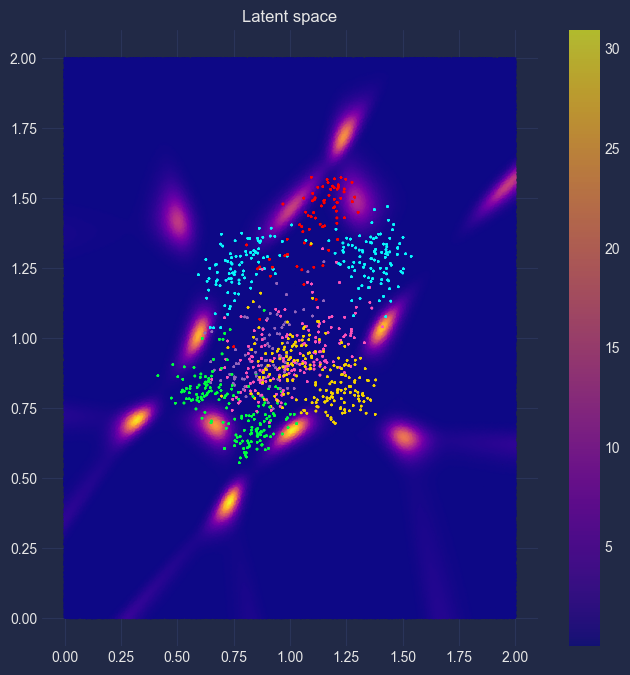

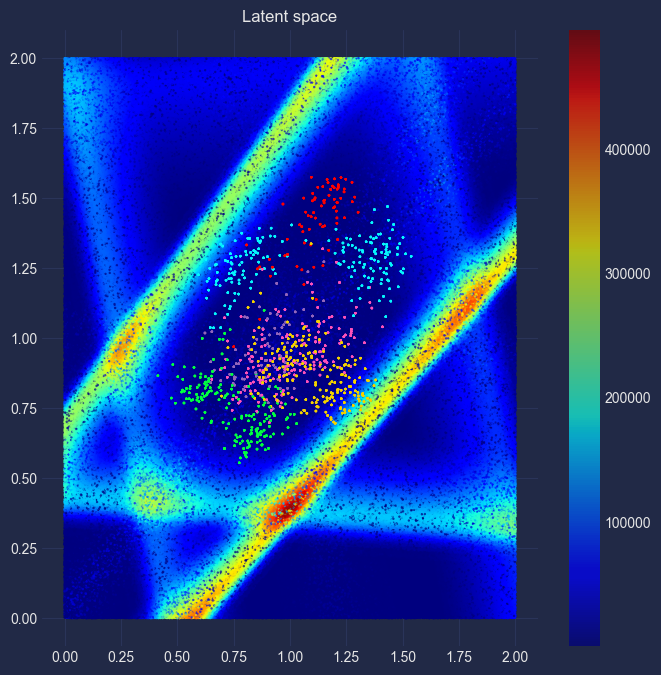

 40%|████      | 40014/100001 [07:07<7:00:30,  2.38it/s] 

40000:(beta)=(    0.6251)


 41%|████      | 41025/100001 [07:15<08:05, 121.37it/s] 

41000:(beta)=(    0.6573)


 42%|████▏     | 42024/100001 [07:23<07:41, 125.59it/s]

42000:(beta)=(    0.8939)


 43%|████▎     | 43022/100001 [07:31<08:12, 115.59it/s]

43000:(beta)=(    0.9960)


 44%|████▍     | 44025/100001 [07:40<07:23, 126.31it/s]

44000:(beta)=(    0.8172)


 45%|████▌     | 45025/100001 [07:48<07:20, 124.78it/s]

45000:(beta)=(    0.6138)


 46%|████▌     | 46023/100001 [07:56<07:07, 126.13it/s]

46000:(beta)=(    0.6771)


 47%|████▋     | 47014/100001 [08:04<06:48, 129.77it/s]

47000:(beta)=(    0.9165)


 48%|████▊     | 48026/100001 [08:12<06:52, 126.10it/s]

48000:(beta)=(    0.9889)


 49%|████▉     | 49025/100001 [08:20<06:42, 126.78it/s]

49000:(beta)=(    0.7907)


 50%|████▉     | 49989/100001 [08:40<06:38, 125.52it/s]

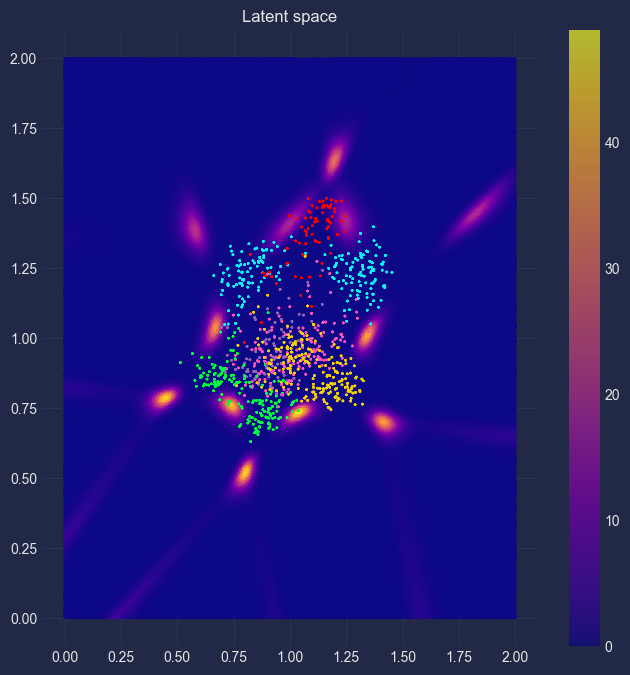

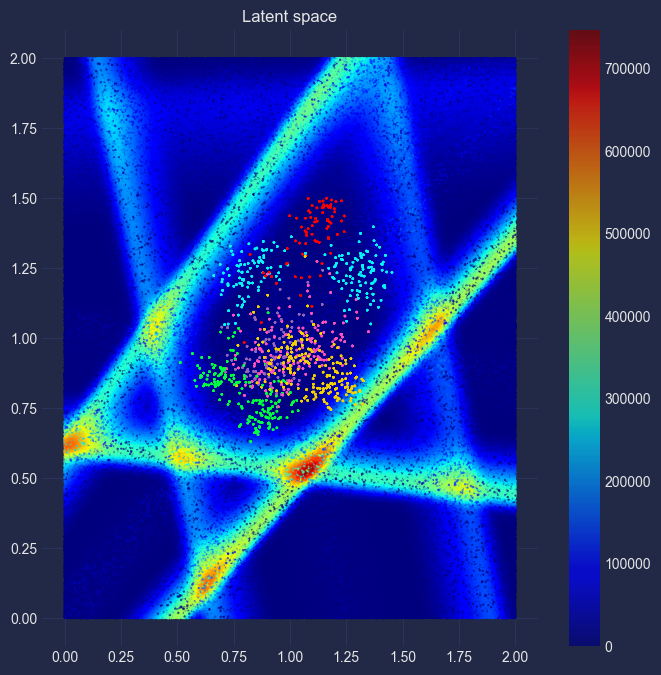

 50%|█████     | 50011/100001 [08:47<4:59:39,  2.78it/s]

50000:(beta)=(    0.6058)


 51%|█████     | 51015/100001 [08:57<08:27, 96.56it/s]  

51000:(beta)=(    0.6992)


 52%|█████▏    | 52014/100001 [09:06<07:05, 112.77it/s]

52000:(beta)=(    0.9370)


 53%|█████▎    | 53014/100001 [09:15<07:06, 110.27it/s]

53000:(beta)=(    0.9786)


 54%|█████▍    | 54014/100001 [09:25<09:41, 79.02it/s] 

54000:(beta)=(    0.7643)


 55%|█████▌    | 55018/100001 [09:34<07:28, 100.26it/s]

55000:(beta)=(    0.6012)


 56%|█████▌    | 56022/100001 [09:43<06:20, 115.50it/s]

56000:(beta)=(    0.7230)


 57%|█████▋    | 57021/100001 [09:52<06:30, 110.17it/s]

57000:(beta)=(    0.9551)


 58%|█████▊    | 58022/100001 [10:01<06:15, 111.80it/s]

58000:(beta)=(    0.9650)


 59%|█████▉    | 59017/100001 [10:10<06:03, 112.73it/s]

59000:(beta)=(    0.7385)


 60%|█████▉    | 60000/100001 [10:30<05:49, 114.52it/s]

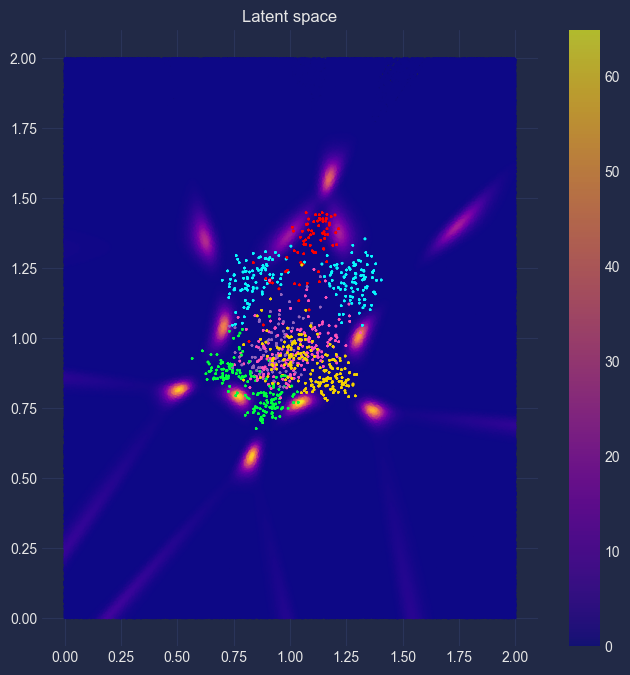

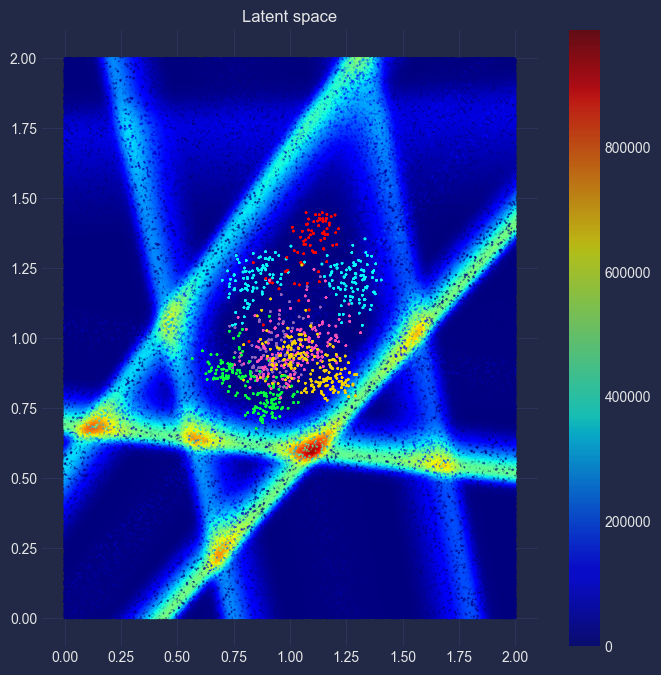

 60%|██████    | 60011/100001 [10:42<6:00:53,  1.85it/s]

60000:(beta)=(    0.6001)


 61%|██████    | 61024/100001 [10:50<05:20, 121.76it/s] 

61000:(beta)=(    0.7481)


 62%|██████▏   | 62015/100001 [10:58<05:10, 122.45it/s]

62000:(beta)=(    0.9705)


 63%|██████▎   | 63016/100001 [11:07<05:16, 116.93it/s]

63000:(beta)=(    0.9486)


 64%|██████▍   | 64021/100001 [11:15<05:04, 118.26it/s]

64000:(beta)=(    0.7138)


 65%|██████▌   | 65013/100001 [11:24<05:01, 116.10it/s]

65000:(beta)=(    0.6025)


 66%|██████▌   | 66016/100001 [11:33<04:54, 115.39it/s]

66000:(beta)=(    0.7742)


 67%|██████▋   | 67018/100001 [11:42<05:07, 107.31it/s]

67000:(beta)=(    0.9829)


 68%|██████▊   | 68018/100001 [11:51<04:38, 114.76it/s]

68000:(beta)=(    0.9295)


 69%|██████▉   | 69019/100001 [12:00<04:15, 121.43it/s]

69000:(beta)=(    0.6906)


 70%|██████▉   | 70000/100001 [12:20<04:24, 113.39it/s]

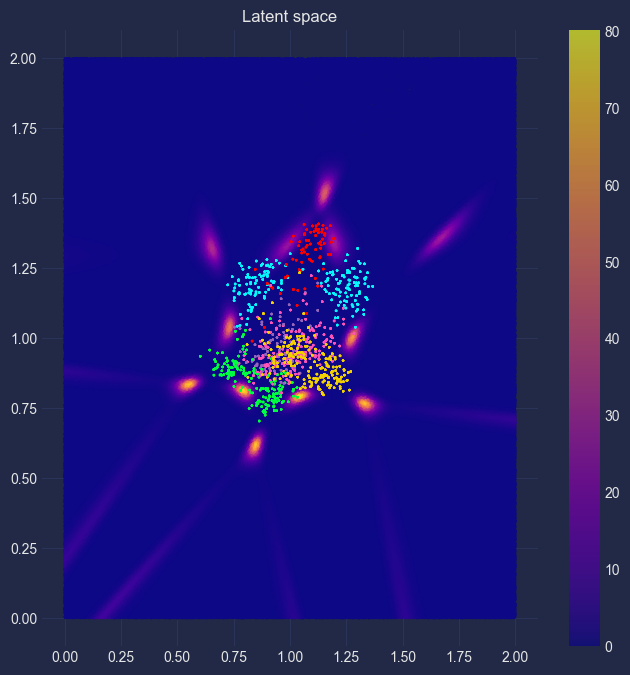

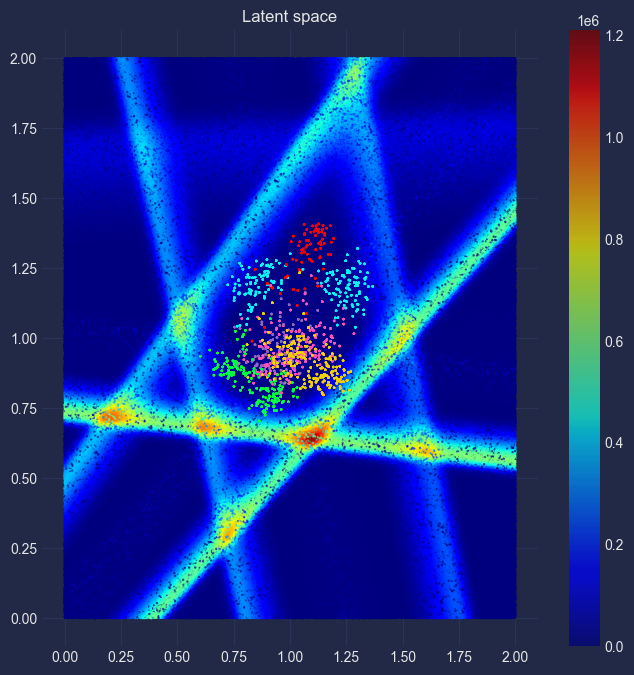

 70%|███████   | 70009/100001 [12:31<4:38:38,  1.79it/s]

70000:(beta)=(    0.6084)


 71%|███████   | 71021/100001 [12:39<04:08, 116.39it/s] 

71000:(beta)=(    0.8007)


 72%|███████▏  | 72019/100001 [12:47<03:45, 124.07it/s]

72000:(beta)=(    0.9920)


 73%|███████▎  | 73019/100001 [12:56<03:42, 121.14it/s]

73000:(beta)=(    0.9082)


 74%|███████▍  | 74018/100001 [13:04<03:34, 121.07it/s]

74000:(beta)=(    0.6694)


 75%|███████▌  | 75013/100001 [13:12<03:22, 123.70it/s]

75000:(beta)=(    0.6177)


 76%|███████▌  | 76020/100001 [13:21<03:23, 118.09it/s]

76000:(beta)=(    0.8272)


 77%|███████▋  | 77021/100001 [13:29<03:05, 123.64it/s]

77000:(beta)=(    0.9977)


 78%|███████▊  | 78014/100001 [13:37<02:58, 123.17it/s]

78000:(beta)=(    0.8849)


 79%|███████▉  | 79022/100001 [13:46<02:51, 122.66it/s]

79000:(beta)=(    0.6505)


 80%|███████▉  | 79996/100001 [14:10<02:47, 119.36it/s]

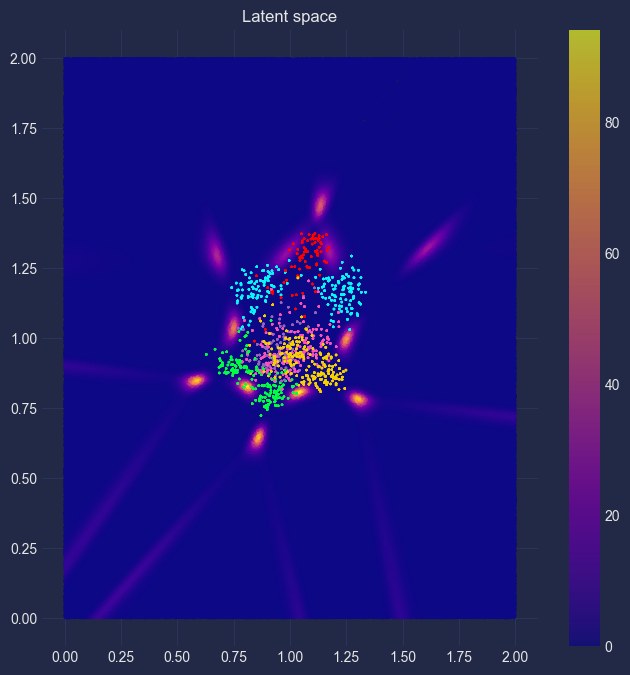

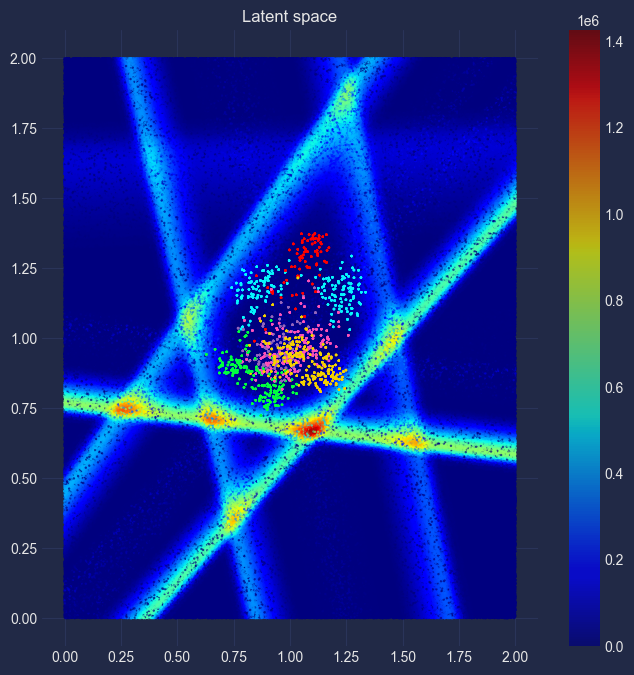

 80%|████████  | 80013/100001 [14:15<2:19:57,  2.38it/s]

80000:(beta)=(    0.6302)


 81%|████████  | 81021/100001 [14:24<02:44, 115.69it/s] 

81000:(beta)=(    0.8533)


 82%|████████▏ | 82023/100001 [14:33<02:39, 112.44it/s]

82000:(beta)=(    1.0000)


 83%|████████▎ | 83015/100001 [14:41<02:15, 125.25it/s]

83000:(beta)=(    0.8602)


 84%|████████▍ | 84017/100001 [14:49<02:14, 119.26it/s]

84000:(beta)=(    0.6342)


 85%|████████▌ | 85014/100001 [14:57<02:00, 124.38it/s]

85000:(beta)=(    0.6458)


 86%|████████▌ | 86022/100001 [15:06<01:55, 120.99it/s]

86000:(beta)=(    0.8783)


 87%|████████▋ | 87014/100001 [15:14<01:45, 122.91it/s]

87000:(beta)=(    0.9987)


 88%|████████▊ | 88022/100001 [15:22<01:35, 125.32it/s]

88000:(beta)=(    0.8344)


 89%|████████▉ | 89022/100001 [15:31<01:30, 120.88it/s]

89000:(beta)=(    0.6208)


 90%|████████▉ | 89993/100001 [15:50<01:26, 115.09it/s]

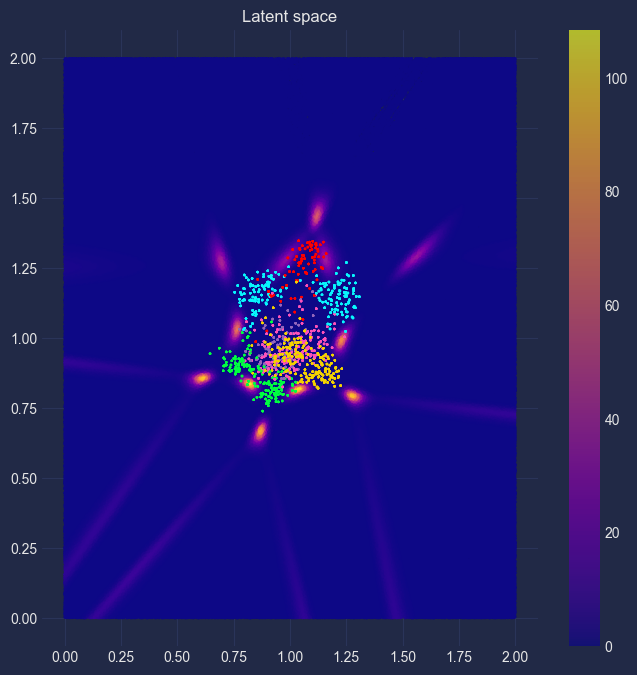

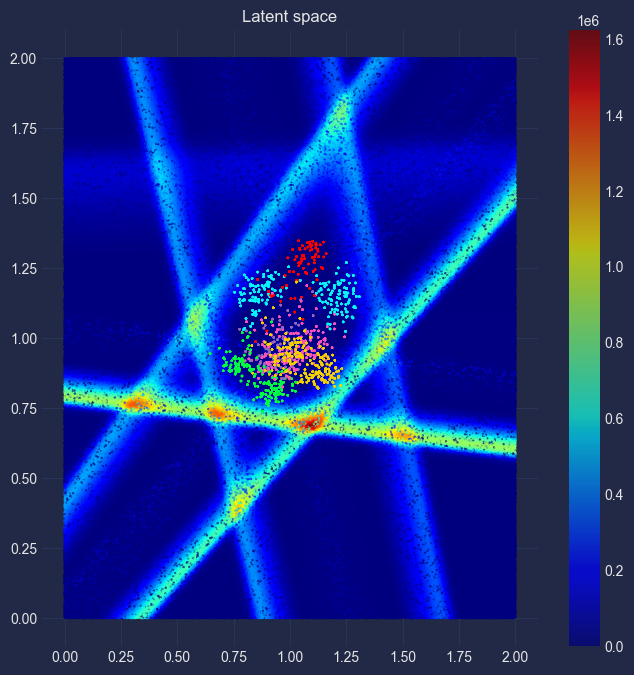

 90%|█████████ | 90009/100001 [15:59<1:09:05,  2.41it/s]

90000:(beta)=(    0.6640)


 91%|█████████ | 91025/100001 [16:07<01:13, 121.87it/s] 

91000:(beta)=(    0.9021)


 92%|█████████▏| 92019/100001 [16:15<01:09, 114.47it/s]

92000:(beta)=(    0.9939)


 93%|█████████▎| 93020/100001 [16:24<00:57, 121.02it/s]

93000:(beta)=(    0.8079)


 94%|█████████▍| 94022/100001 [16:32<00:47, 127.06it/s]

94000:(beta)=(    0.6106)


 95%|█████████▌| 95023/100001 [16:40<00:39, 124.72it/s]

95000:(beta)=(    0.6846)


 96%|█████████▌| 96020/100001 [16:48<00:31, 125.38it/s]

96000:(beta)=(    0.9240)


 97%|█████████▋| 97023/100001 [16:56<00:24, 123.56it/s]

97000:(beta)=(    0.9857)


 98%|█████████▊| 98022/100001 [17:04<00:16, 121.53it/s]

98000:(beta)=(    0.7814)


 99%|█████████▉| 99025/100001 [17:12<00:07, 125.94it/s]

99000:(beta)=(    0.6038)


100%|█████████▉| 99991/100001 [17:20<00:00, 123.01it/s]

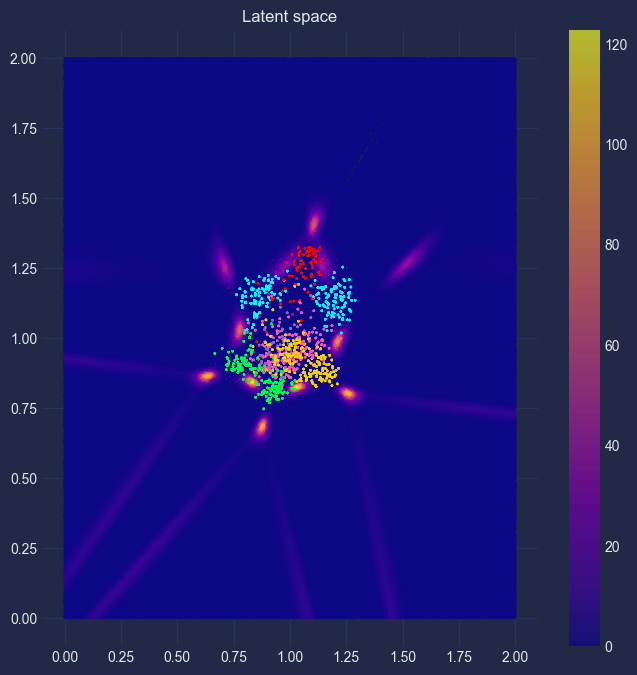

100%|█████████▉| 99991/100001 [17:40<00:00, 123.01it/s]

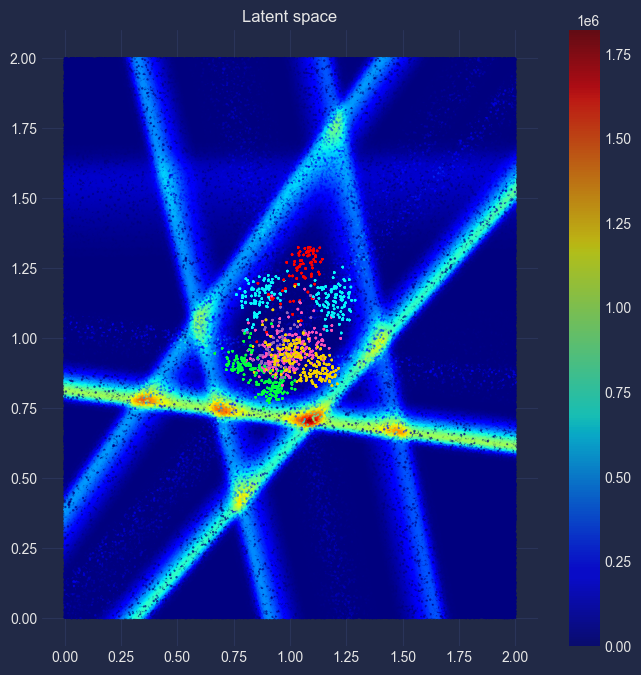

100%|██████████| 100001/100001 [17:41<00:00, 94.24it/s]

100000:(beta)=(    0.7073)


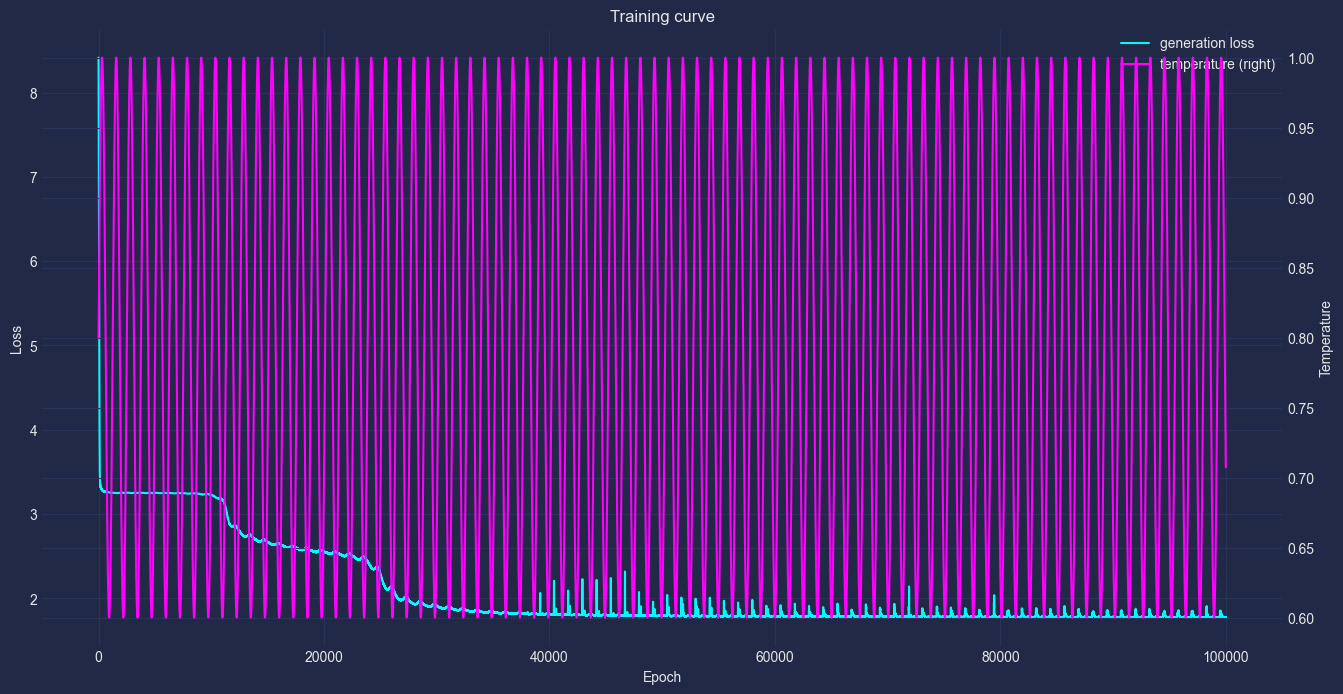

In [4]:
# Optimizer
params = list(encoder.parameters()) + list(decoder.parameters())
#optimizer = optim.Adam(params, lr=5e-5, betas=(0.5, 0.999))
optimizer = optim.SGD(params, lr=1e-3, momentum=0.1)

# Training loop
ac_list = []
gen_loss_list = []
val_list = []
val_gen_loss_list = []
beta_list = []
fifs_list = []

beta_min = 1/5   # must be less than 1/2
cyclical_beta = (1 - beta_min) + beta_min * np.sin(500/n_epoch * np.arange(n_epoch))

for j in tqdm(range(n_epoch)):
    optimizer.zero_grad()
    
    loc, scale = encoder(x)
    prior = Normal(torch.zeros_like(loc), torch.ones_like(scale))
    posterior = Normal(loc, scale)
    z_sample = torch.add(loc, scale.pow_(prior.sample()))
    z_sample.requires_grad_(True)
    
    dec = decoder(z_sample)
    dec.requires_grad_(True)
    log_probs = Bernoulli(probs=dec.pow_(cyclical_beta[j])).log_prob(y)
 
    if j % 10000 == 0:
        n_vis = 10
        enc_test = torch.cat([z_sample for i in range(n_vis)], dim=0).detach().numpy()
        enc_test_label = np.tile(yl_train, (n_vis))
        n_vis = 1000
        z_range = np.random.uniform(0, 2, size=(batch_size*n_vis, latent_dim))
        decoder_params = dict(decoder.named_parameters())
        mfs = np.hstack([compute_magnification_factor(compute_jacobian(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True))).detach().numpy() for i in range(n_vis)])
        fifs = np.hstack([compute_fisher_information_factor(compute_logprobs(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True), cyclical_beta, j)).detach().numpy() for i in range(n_vis)])

        rcParams['figure.figsize'] = 8, 8
        plt.figure()
        plt.scatter(z_range[:, 0], z_range[:, 1],
                    #c=mfs, cmap=plt.cm.Reds,
                    c=mfs, cmap=plt.cm.plasma,
                    edgecolor='none', alpha=0.7, s=3)
        plt.colorbar()
        for i in range(len(np.unique(yl_train))):
            plt.scatter(enc_test[enc_test_label==i, 0], enc_test[enc_test_label==i, 1], 
                        edgecolor='none', alpha=0.7, s=3)
        plt.title('Latent space')
        plt.show()
        
        rcParams['figure.figsize'] = 8, 8
        plt.figure()
        plt.scatter(z_range[:, 0], z_range[:, 1],
                    #c=fifs, cmap=plt.cm.Greens,
                    c=fifs, cmap=plt.cm.jet,
                    edgecolor='none', alpha=0.7, s=3)
        plt.colorbar()
        for i in range(len(np.unique(yl_train))):
            plt.scatter(enc_test[enc_test_label==i][:, 0], enc_test[enc_test_label==i][:, 1],         
                        edgecolor='none', alpha=0.7, s=3)
        plt.title('Latent space')
        plt.show()


    # Loss functions
    kl_divergence = torch.distributions.kl_divergence(posterior, prior).mean()
    recon_likelihood = log_probs.sum(dim=1).mean()
    gen_loss = torch.sub(kl_divergence, recon_likelihood)
    
    gen_loss.backward(retain_graph=True)
    optimizer.step()

    with torch.no_grad():
        correct = (y.argmax(dim=1) == dec.argmax(dim=1)).float()
        accuracy = correct.mean()
        ac_list.append(accuracy.item())
        gen_loss_list.append(gen_loss.item())
        beta_list.append(cyclical_beta[j])
        
        if j % 1000 == 0:
            print("%5d:(beta)=(%10.4f)" % (j, cyclical_beta[j]))

rcParams['figure.figsize'] = 16, 8
fig, ax1 = plt.subplots() 
ax2 = ax1.twinx()
ax1.plot(np.arange(n_epoch), np.asarray(gen_loss_list), label='generation loss')
#ax1.plot(np.arange(n_epoch), np.asarray(val_gen_loss_list), label='validation generation loss')
ax2.plot(np.arange(n_epoch), np.asarray(beta_list), label='temperature (right)', color='magenta')
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=1, borderaxespad=0.1)
plt.title('Training curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Temperature')
plt.show()

In [5]:
loc, scale = encoder(x)
z_sample = torch.add(loc, scale.pow_(prior.sample()))
z_sample.requires_grad_(True)
dec = decoder(z_sample)
dec.requires_grad_(True)
jacobian = compute_jacobian(decoder, decoder_params, z_sample)

n_vis = 10
enc_test = torch.cat([z_sample for i in range(n_vis)], dim=0).detach().numpy()
enc_test_label = np.tile(yl_train, (n_vis))
n_vis = 1000
z_range = np.random.uniform(0, 2, size=(batch_size*n_vis, latent_dim))
decoder_params = dict(decoder.named_parameters())
mfs = np.hstack([compute_magnification_factor(compute_jacobian(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True))).detach().numpy() for i in range(n_vis)])
fifs = np.hstack([compute_fisher_information_factor(compute_logprobs(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True), cyclical_beta, j)).detach().numpy() for i in range(n_vis)])

print(mfs.shape)
print(z_range[:, 0].shape)
print(z_range[:, 1].shape)
print(enc_test.shape)
print(enc_test_label.shape)

(898000,)
(898000,)
(898000,)
(8980, 2)
(8980,)


In [6]:
print(enc_test)
print(enc_test_label)

[[0.9058645  0.7837271 ]
 [1.0680579  0.866356  ]
 [0.93121636 0.9263764 ]
 ...
 [0.8341497  0.95677114]
 [1.1527965  0.8722595 ]
 [1.2066872  1.1825869 ]]
[3 2 5 ... 9 2 6]


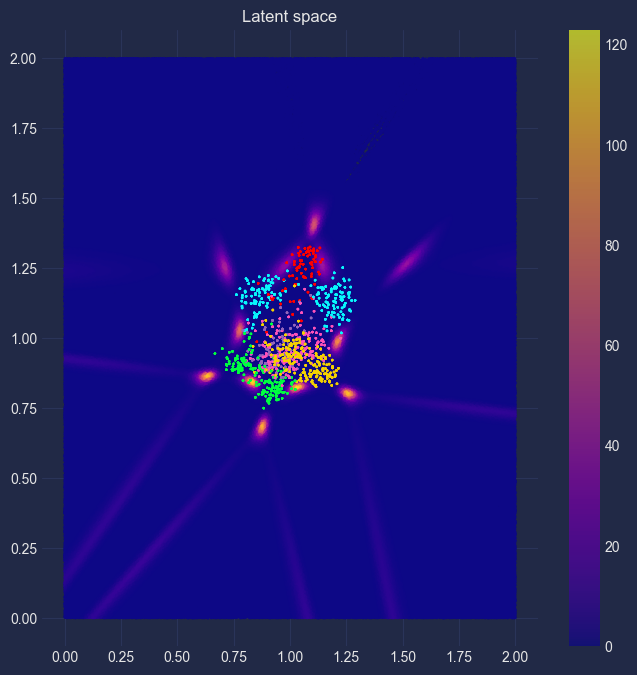

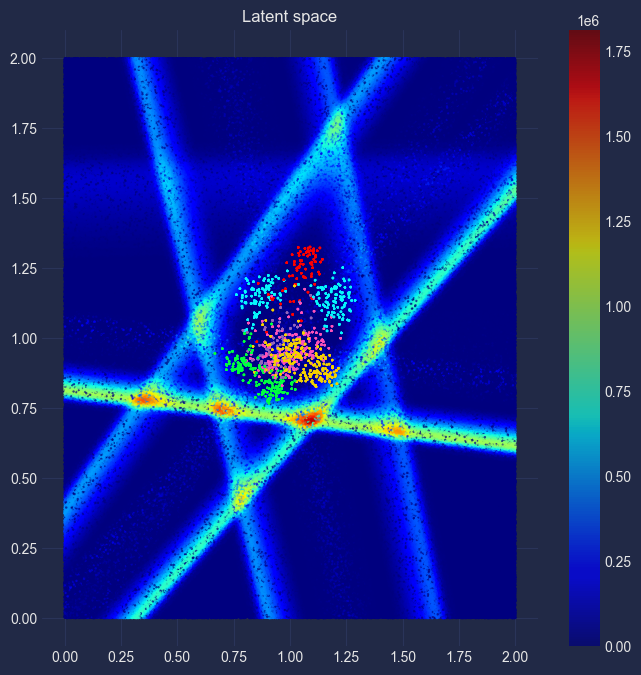

In [7]:
rcParams['figure.figsize'] = 8, 8
plt.figure()
plt.scatter(z_range[:, 0], z_range[:, 1],
            c=mfs, cmap=plt.cm.plasma,
            edgecolor='none', alpha=0.7, s=3)
plt.colorbar()
for i in range(len(np.unique(yl_train))):
    plt.scatter(enc_test[enc_test_label==i, 0], enc_test[enc_test_label==i, 1], 
                edgecolor='none', alpha=0.7, s=3)
plt.title('Latent space')
plt.show()

rcParams['figure.figsize'] = 8, 8
plt.figure()
plt.scatter(z_range[:, 0], z_range[:, 1],
            c=fifs, cmap=plt.cm.jet,
            edgecolor='none', alpha=0.7, s=3)
plt.colorbar()
for i in range(len(np.unique(yl_train))):
    plt.scatter(enc_test[enc_test_label==i][:, 0], enc_test[enc_test_label==i][:, 1],         
                edgecolor='none', alpha=0.7, s=3)
plt.title('Latent space')
plt.show()